<a href="https://colab.research.google.com/github/kubicndmr/FAU-SLU2024/blob/main/Exercise_3_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise 3:**

# **Word and Sentence Embeddings**
---
The context has an important role in the meaning of words. Words that occur in similar contexts tend to have similar meanings. In this exercise, we will see techniques for learning representations of the meanings of words. Then, we will extend this idea to sentences and perform a semantic analysis task by using machine learning classfiers.


### **Acknowledgement**
Some code snippets are retrieved from Standford CS224N material. See their website for more details.

You can also see these resources for further reading.

[1] Jurafsky, Daniel, and James H. Martin. "Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition."

## **3.1 Word Vectors**

Typically, the representation is a real-valued vector that encodes the meaning of the word in such a way that the words that are closer in the vector space are expected to be similar in meaning.

Note that word vectors and word embeddings are often used interchangeably. They refer to the mathematical representation of the words as vectors in the feature space.



---


First, install the necessary packages that do not exist in the environment.

In [1]:
!pip install transformers
!pip install datasets
!pip install --upgrade gensim

Then, import necessary packages:

*   NumPy is an open source project that enables numerical computing with Python
*   sklearn is an open source machine learning library
*   matplotlib is a widely used Python package for creating visualizations

In [2]:
import re
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

In [3]:
# define parameters
START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 50

Let's get some insights from the dataset we will be working on

In [4]:
# load the imbd dataset
sentiment_dataset = load_dataset("mteb/tweet_sentiment_extraction")

# get subset only
data = sentiment_dataset["train"][:NUM_SAMPLES]

# see how data classes look like
print(data.keys())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dict_keys(['id', 'text', 'label', 'label_text'])


The dataset has three classes: positive, negative, and neutral. Our task is classifiying tweets given in the text column to these classes. Examples from these classes are given below.

In [5]:
def print_example(data, idx):
  print('\nID:\t\t', data['id'][idx])
  print('Text:\t\t', data['text'][idx])
  print('Label:\t\t',data['label'][idx])
  print('Label_Text:\t',data['label_text'][idx])

In [6]:
# Neutral example
print_example(data, 10)

# Positive Example
print_example(data, 11)

# Negative Example
print_example(data, 13)


ID:		 2339a9b08b
Text:		  as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
Label:		 1
Label_Text:	 neutral

ID:		 16fab9f95b
Text:		 I really really like the song Love Story by Taylor Swift
Label:		 2
Label_Text:	 positive

ID:		 04dd1d2e34
Text:		 i want to go to music tonight but i lost my voice.
Label:		 0
Label_Text:	 negative


### **Question:** How can we convert the text into numbers/vectors/tensors such that we can process them mathematically?  

### **3.1.1 One-Hot Vector**

A straightforward method is to create a one-hot vector and represent each word with a unique array of numbers. We can do it in two steps:

  * Start with finding a dictionary size of the dataset, i.e., number of unique words.

  * After finding the dictionary size, create a one-hot coded vector for each word

▶*TODO* Complete `dictionary_size` function

In [7]:
def dictionary_size(data):
  '''
  This function will return number of unique words in the given dataset.
  For simplicity, consider each word as th array of strings between two
  spaces. Count words written with combinations as new words.
  For example 'I'm' and 'I', 'am' are three different words.

  Params:
        data (dictionary): corpus of documents
  Return:
        dict_size (integer): vocabulary size of the given dataset

  '''
  unique_words = set()
  text_data = data['text']

  # ------------------
  # Write your implementation here.

  for t in text_data:
    words = t.split()
    unique_words.update(words)

  # ------------------

  return len(unique_words)

In [8]:
# Some sanity check (note that this is not an exhaustive test)
assert (dictionary_size(sentiment_dataset["train"][:2]) == 16), f'The correct count is 16, yours is {dictionary_size(sentiment_dataset["train"][:2])}'
assert (dictionary_size(sentiment_dataset["train"][:10]) == 74), f'The correct count is 74, yours is {dictionary_size(sentiment_dataset["train"][:10])}'

print("All good!")

All good!


In [9]:
# get the size of dataset
dataset_size = dictionary_size(data)
print(f'The number of uniq words in the dataset is: {dataset_size}')

The number of uniq words in the dataset is: 432


Now, lets observe the vocabulary size of the dataset as it grows. Initially, we set `NUM_SAMPLES` to 50. Change it iteratively and see how it grows.

In [10]:
vocab_size = []
num_sample_list = [15, 50, 150, 500, 1500, 5000, 15000, 50000, 150000]

for num_samples in num_sample_list:
  vocab_size.append(dictionary_size(sentiment_dataset["train"][:num_samples]))

Plot it!

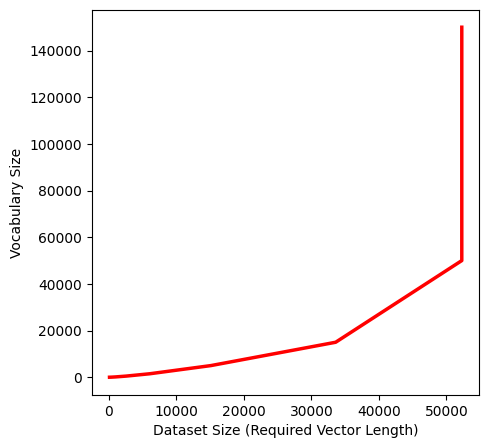

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(vocab_size, num_sample_list, color='red', linewidth=2.5)
plt.xlabel('Dataset Size (Required Vector Length)')
plt.ylabel('Vocabulary Size')
plt.show()

#### **There are two problems**

As you can see, this is not a feasible approach. The number of unique vectors are growing exponentially and even in a relatively small dataset, created one-hot vectors will occupy huge part of the memory or not fit in it at all. We need to map them into much lower dimensions.

Moreover, we want to create word vectors such that they contain also semantic relationships. This information is **not** encoded in one-hot vectors. Ideally, we want something like this.


![picture](https://drive.google.com/uc?export=view&id=1-Y9WzaKR6SI3cYp_yp_RcDDPC9zK9I9A)

(Image retrieved from: https://web.stanford.edu/~jurafsky/slp3/6.pdf)


### **3.1.2 Co-Occurence Matirx**

To respond to these two problems, we can use a co-occurrence matrix to integrate information on word relationships into word vectors and use dimensionality reduction techniques to keep vector size lower.

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use `<START>` and `<END>` tokens to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Singular Value Decomposition (SVD), akin to PCA, selecting the top $k$ principal components. The SVD process decomposes the co-occurrence matrix $A$ into singular values in the diagonal $S$ matrix and new, shorter word vectors in $U_k$.

This dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

In [12]:
def distinct_words(corpus):
    unique_words = set()

    for document in corpus:
        unique_words.update(document)

    corpus_words = sorted(unique_words)
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

▶*TODO* Complete `compute_co_occurrence_matrix` function

In [13]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    # ------------------
    # Write your implementation here.
    words, n_words = distinct_words(corpus)
    word2ind = {word: i for i, word in enumerate(words)}
    M = np.zeros((n_words, n_words))

    for document in corpus:
        for i, word in enumerate(document):
            word_idx = word2ind[word]
            start = max(0, i - window_size)
            end = min(len(document), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    context_word = document[j]
                    context_word_idx = word2ind[context_word]
                    M[word_idx, context_word_idx] += 1

    # ------------------
    return M, word2ind

In [14]:
# Some sanity check (note that this is not an exhaustive test)

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


▶*TODO* Create a function for reducing dimensionality with SVD

In [15]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, n_components=2, n_iter=10):
  # ------------------
  # Write your implementation here.
  svd = TruncatedSVD(n_components=n_components, n_iter=n_iter)
  M_reduced = svd.fit_transform(M)
  # ------------------
  return M_reduced

Create a function for plotting words via M matrix

In [16]:
def plot_embeddings(M_reduced, word2ind, words):
  print(words)
  embeddings = [M_reduced[word2ind[word]] for word in words]
  embeddings = np.array(embeddings)

  plt.figure(figsize=(6, 6))
  for i, word in enumerate(words):
      x, y = embeddings[i]
      plt.scatter(x, y)
      plt.text(x + 0.01, y + 0.01, word, fontsize=12)

  plt.title('Word Embeddings')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.grid(True)
  plt.show()

In [17]:
def get_corpus(data):
    return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in data['text']]

['hope', 'hopeful', 'hoping', 'funny', 'fun', 'smiles', 'happy', 'unhappy']


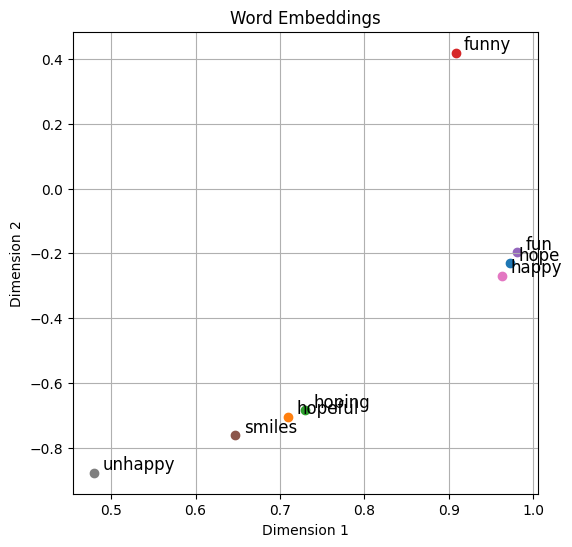

In [18]:
corpus = get_corpus(data)
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, n_components=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['hope', 'hopeful', 'hoping', 'funny', 'fun', 'smiles', 'happy', 'unhappy']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### **Can we do it better?**


It seems like some groups have occurred. 'fun', 'hope', and 'happy' are very close to each other and 'unhappy' is very far from them. Similarly 'smiles', 'hoping' and 'hopeful' are together, all these have positive feelings and might might be grouped together. That is a very good achievement!

However, 'smiles' is closer to 'unhappy' than 'happy' or 'funny'. This is unexpected. Also 'hoping', 'hopeful', and 'hope' are not very close to each other.

Can we improve these representations with neural networks?

### **3.1.3 GloVe**

GloVe stands for global vectors for word representation. It is an unsupervised learning algorithm developed for generating word embeddings by aggregating global word-word co-occurrence matrix from a corpus. The resulting embeddings show interesting linear substructures of the word in vector space.

The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence. Owing to the fact that the logarithm of a ratio equals the difference of logarithms, this objective associates (the logarithm of) ratios of co-occurrence probabilities with vector differences in the word vector space. Because these ratios can encode some form of meaning, this information gets encoded as vector differences as well. For this reason, the resulting word vectors perform very well on word analogy tasks

See paper for the details: http://nlp.stanford.edu/pubs/glove.pdf


  ![picture](https://drive.google.com/uc?export=view&id=1NzDecg8hkmGz-prcB3LrHVqGDjGMOGoB)




Let's implement it!

To compute GloVe embeddings we will benefit from popular gensim library. Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. See: https://radimrehurek.com/gensim/. We alread instlled it at the beggining.

In [19]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-200")

In [20]:
def get_M_glove(model, words):
  '''This function computes word vectors with glove model
  and creates a matrix M by concatanation'''
  word2ind = {word: i for i, word in enumerate(words)}
  M_glove = np.stack([model.get_vector(w) for w in words])
  return M_glove, word2ind


In [21]:
M_glove, word2ind = get_M_glove(model, words)

Lets map these embeddings to lower dim (again 2D)

▶*TODO* Reduce the dimension of `M_glove_reduced` embeddings to 2

In [23]:
# ------------------
# Write your implementation here.
M_glove_reduced = reduce_to_k_dim(M_glove, n_components=2)
# ------------------

print(f"""The original size of embeedings for {len(words)} words is {M_glove.shape}.
The reduced shape of embeddings is {M_glove_reduced.shape}. Succesfull!""")

The original size of embeedings for 8 words is (8, 200).
The reduced shape of embeddings is (8, 2). Succesfull!


▶*TODO* Plot `M_glove_reduced` embeddings

['hope', 'hopeful', 'hoping', 'funny', 'fun', 'smiles', 'happy', 'unhappy']


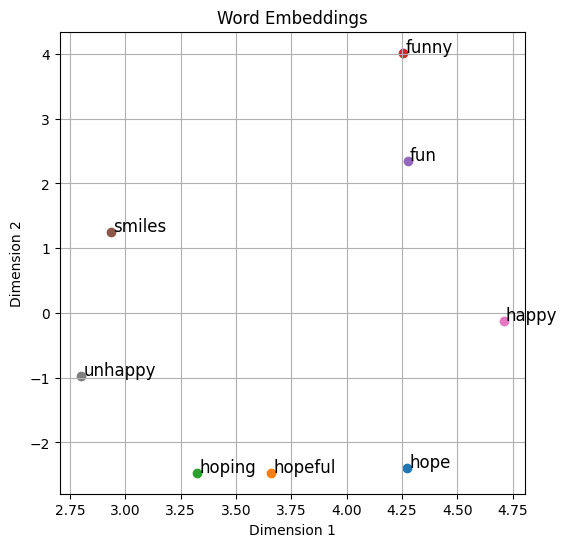

In [24]:
# ------------------
# Write your implementation here.
plot_embeddings(M_glove_reduced, word2ind, words)
# ------------------

▶*TODO* Compare the results of glove embeddings with the previous method. Explain what do you observe?

> Your answer:



## **3.1 Sentence Embeddings**

So far, we worked on word embeddings and succesfully integrated semantic information into low dimensional vectors. We can use these vectors already in our sentiment analysis but the task is still difficult because we need to analyze each word in sentences.

An another approach is to create embeddings directly for sentences. There could be many models but we will use BERT model in this exercise.

If you are not familiar with BERT, check out this blog: https://jalammar.github.io/illustrated-bert/

Lets implement it. With Huggingface transformers, it is quite easy!

In [25]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [26]:
def create_sentence_embeddings(sentences):

    inputs = tokenizer(sentences, return_tensors='pt',
                       padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state

    sentence_embeddings = torch.mean(last_hidden_states, dim=1)
    return sentence_embeddings

Before starting, simplify the task and create a dataset with only positive and negative samples

In [27]:
dataset_size = 100
dataset_counter = 0
dataset, labelset = [], []

idx = 0
while dataset_counter < dataset_size:
  sample = sentiment_dataset["train"][idx]

  if sample['label'] == 0 or sample['label'] == 2:
    dataset.append(sample['text'])
    labelset.append(sample['label'])
    dataset_counter += 1

  idx += 1

In [28]:
print(f'Dataset size: {len(dataset)}/{len(labelset)}')

Dataset size: 100/100


Let's create embeddings for sentences

In [29]:
embeddings = create_sentence_embeddings(dataset)
print(f'The shape of embeddings are {embeddings.shape}.')

The shape of embeddings are torch.Size([100, 768]).


Create reference sentences

In [30]:
positive_reference = ["That is very positive"]
negative_reference = ["That is very negative"]

Create embeddings for references

In [31]:
embeddings_positive = create_sentence_embeddings(positive_reference)
embeddings_negative = create_sentence_embeddings(negative_reference)
print(f'The shape of positive embeddings are {embeddings_positive.shape}.')
print(f'The shape of negative embeddings are {embeddings_negative.shape}.')

The shape of positive embeddings are torch.Size([1, 768]).
The shape of negative embeddings are torch.Size([1, 768]).


Now we use cosine similarity, and decide for each sentence, if they are close to positive reference sentence or negative

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_positive = cosine_similarity(embeddings_positive, embeddings)
similarity_negative = cosine_similarity(embeddings_negative, embeddings)

similarity_positive = np.squeeze(similarity_positive)
similarity_negative = np.squeeze(similarity_negative)

Finally, make predictions. If a sentence is closer to negative reference, we classify it as negative. And if a sentence is closer to positive reference, we classify it as positive.

In [33]:
predictions = np.zeros((len(labelset),))
predictions[similarity_positive > similarity_negative] = 2

Compute accuracy and see the performance

In [34]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labelset, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.62


We already achieved slightly above the chance level without any training. We can improve it by finetunning the model with our data, using more powerful models, or better reference sentences.  